In [1]:
import wrangle as w
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
df = w.get_cws_data()

In [3]:
train, validate, test, X_train, y_train, X_val, y_val, X_test, y_test = w.train_vailidate_test_split(df, 'bad_resident', 'bad_resident')

In [4]:
# Finding the average risk score for residents
train.risk_score.mean()

591.2880085653105

(array([419.,   0.,   0.,   0.,   1.,  34., 211., 569., 939., 629.]),
 array([  0. ,  83.6, 167.2, 250.8, 334.4, 418. , 501.6, 585.2, 668.8,
        752.4, 836. ]),
 <BarContainer object of 10 artists>)

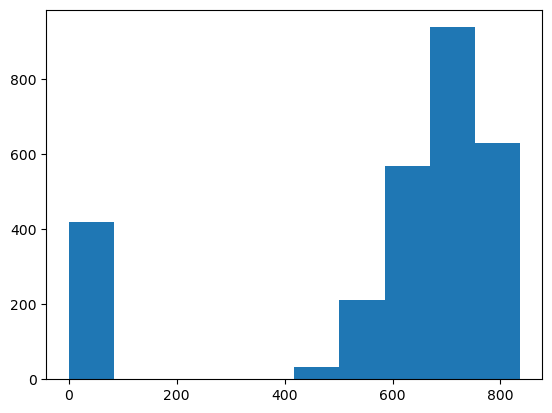

In [5]:
plt.hist(train.risk_score)

In [6]:
# Creating custom bins with 100 range and binning both total train pop and only bad train pop
bins = [300,400,500,600,700,800,900]
risk_bin = pd.cut(train['risk_score'], bins = bins)
bad_risk = pd.cut(train[train.bad_resident == 1].risk_score, bins = bins)

<AxesSubplot:xlabel='risk_score', ylabel='count'>

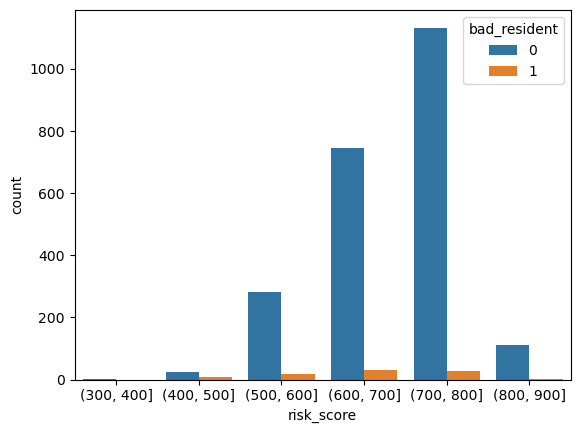

In [7]:
# Residents by risk score and hued by who is a bad resident
sns.countplot(x = risk_bin, hue = train.bad_resident)

<AxesSubplot:xlabel='risk_score', ylabel='count'>

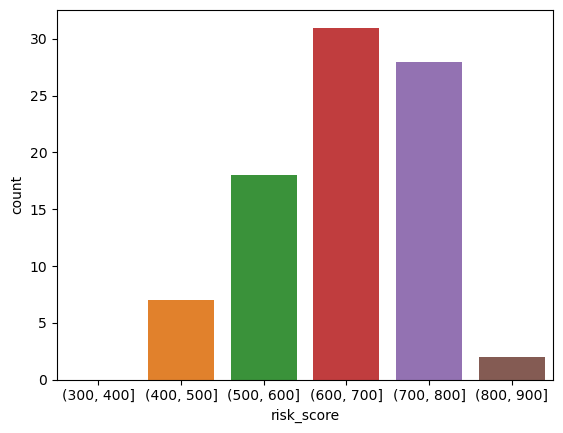

In [8]:
# Plotting only bad residents by risk score
sns.countplot(x = bad_risk)

In [9]:
# Setting the risk scores by bad_res in prep for t test
# Null hypothesis is risk score isnt different
risk_yes = train[train.bad_resident == 1].risk_score
risk_no = train[train.bad_resident == 0].risk_score

In [10]:
# Checking variance
print(risk_no.var(), risk_yes.var())

66143.36855129228 75301.11602891909


In [11]:
# Running ind t-test
t, p = stats.ttest_ind(risk_yes, risk_no, equal_var=False)
t, p / 2

(-2.3936020123384156, 0.009161654230085704)

In [12]:
# Creating a crosstab of risk bins and bad resident
observed = pd.crosstab(train.bad_resident, risk_bin)
observed

risk_score,"(300, 400]","(400, 500]","(500, 600]","(600, 700]","(700, 800]","(800, 900]"
bad_resident,,,,,,
0,1,25,282,744,1133,112
1,0,7,18,31,28,2


In [13]:
# running a chi2 test on the observed crosstab
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p

(41.91179583829077, 6.137517113761328e-08)

## Risk Score is statistically siginificant to bad residents

In [14]:
train.loc[2376]

id                                                       62552
total_charges                                             2.13
amount_paid                                               2.13
open                                                         0
charge_code                                                180
description          Administration Processing Fee for 16 days
prop_id                                                    112
charge_name                      Administration processing fee
sStatus                                                Current
rent                                                      2489
term                                                         6
monthly_inc                                            1500000
GuarantorRequired                                        False
total_inc                                                    0
Recommendation                            A-Meets Requirements
age                                                    

In [15]:
#Finding mean monthly income
train.monthly_inc.mean()

10372.033547466095

In [16]:
# Finding monthly incomes greater than top 1% US earners
len(train[train.monthly_inc <= 20000]) - len(train)

-155

In [17]:
# Turning assumed yearly incomes into monthly incomes
train.monthly_inc = np.where(train.monthly_inc >= 20000, train.monthly_inc/12, train.monthly_inc)

In [18]:
# Sorting new values
train.monthly_inc.sort_values(ascending = False).head(50)

2376    125000.0
968      70000.0
3959     50000.0
1665     29166.0
591      19000.0
1236     18800.0
2699     18750.0
2482     18500.0
2286     18000.0
796      17637.0
3710     17600.0
1381     17500.0
1621     17500.0
4790     17220.0
2281     17166.0
4371     17000.0
1094     17000.0
1279     17000.0
3915     17000.0
413      17000.0
411      17000.0
555      16891.0
1192     16800.0
4578     16667.0
758      16667.0
3922     16667.0
2926     16666.0
2192     16600.0
1879     16517.0
4913     16500.0
1889     16333.0
1839     16000.0
4917     15833.0
2899     15833.0
2857     15833.0
2911     15800.0
1568     15500.0
1424     15000.0
4666     15000.0
666      15000.0
3875     15000.0
2696     15000.0
3400     15000.0
627      15000.0
205      15000.0
4417     15000.0
4454     14750.0
2338     14740.0
4227     14600.0
4481     14583.0
Name: monthly_inc, dtype: float64

In [19]:
train.loc[2376]

id                                                       62552
total_charges                                             2.13
amount_paid                                               2.13
open                                                         0
charge_code                                                180
description          Administration Processing Fee for 16 days
prop_id                                                    112
charge_name                      Administration processing fee
sStatus                                                Current
rent                                                      2489
term                                                         6
monthly_inc                                           125000.0
GuarantorRequired                                        False
total_inc                                                    0
Recommendation                            A-Meets Requirements
age                                                    

In [20]:
# Replacing any blank total income with monthly income * 12
train.total_inc = np.where(train.total_inc == 0, train.monthly_inc * 12, train.total_inc)

In [21]:
# Replacing any blank monthly income with total income / 12
train.monthly_inc = np.where(train.monthly_inc == 0, train.total_inc/12, train.monthly_inc)

In [55]:
# Finding the mean yearly income
train.total_inc.mean()

114690.54996431121

In [54]:
# New monthly mean after adjustments
train.monthly_inc.mean()

6092.059600285507

(0.0, 20000.0)

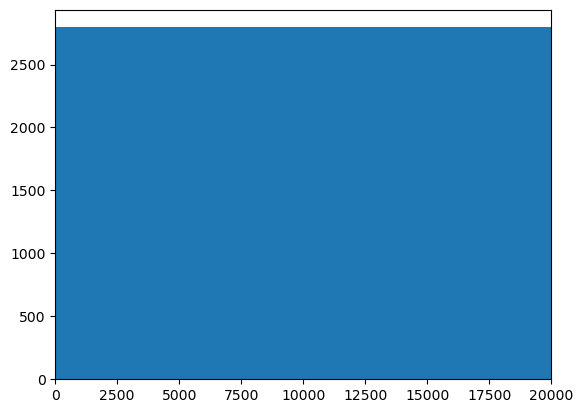

In [24]:
plt.hist(train.monthly_inc)
plt.xlim([0,20000])

(0.0, 20000.0)

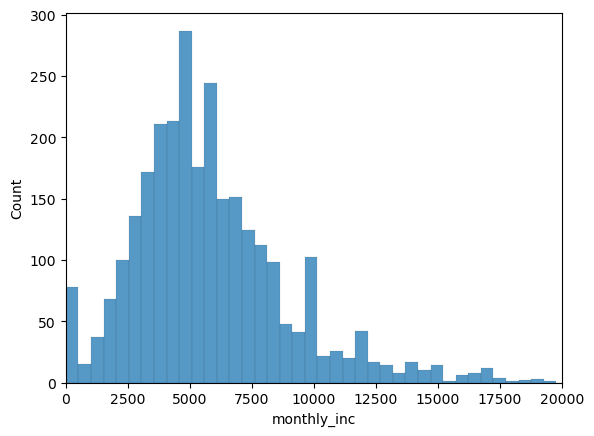

In [25]:
#plotting monthly income
sns.histplot(train.monthly_inc)
plt.xlim([0, 20000])

(0.0, 1000000.0)

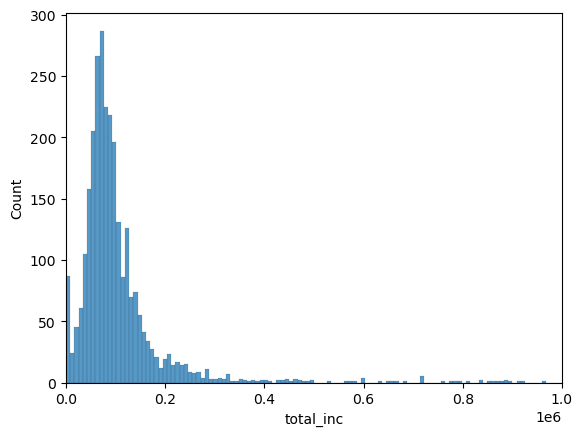

In [26]:
# Plotting yearly income
sns.histplot(train.total_inc)
plt.xlim([0, 1000000])

In [27]:
# Creating the variables for a t test
risk_yes = train[train.bad_resident == 1].monthly_inc
risk_no = train[train.bad_resident == 0].monthly_inc

In [28]:
# Checking variance
print(risk_yes.var(), risk_no.var())

804082141.6810088 18914563.006288163


In [29]:
# Running ind t-test
t, p = stats.ttest_ind(risk_yes, risk_no, equal_var=False)
t, p / 2

(1.0622979322158108, 0.1452550962117374)

In [30]:
# ttest variables
risk_yes = train[train.bad_resident == 1].total_inc
risk_no = train[train.bad_resident == 0].total_inc

In [31]:
# Checking variance
print(risk_yes.var(), risk_no.var())

119994824365.87276 30380411044.511555


In [32]:
# Running ind t-test
t, p = stats.ttest_ind(risk_yes, risk_no, equal_var=False)
t, p / 2

(0.5559071368127685, 0.28971134615296684)

In [33]:
inc_bins = [0, 3000, 6000, 9000, 12000, 15000, 18000, 21000, 10000000]
month = pd.qcut(train.monthly_inc, 4)

<AxesSubplot:xlabel='monthly_inc', ylabel='count'>

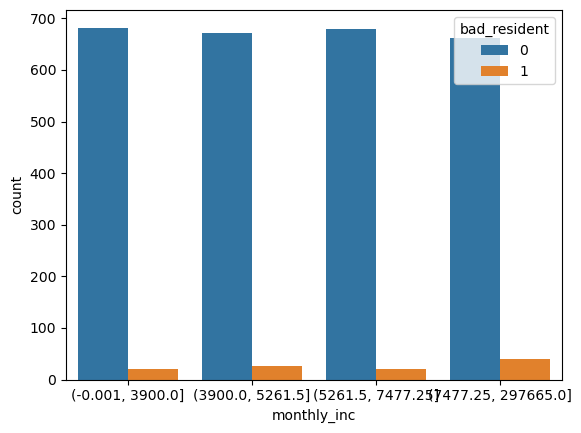

In [34]:
sns.countplot(x = month, hue = train.bad_resident)

In [35]:
# Creating a crosstab of risk bins and bad resident
observed = pd.crosstab(train.bad_resident, month)
observed

monthly_inc,"(-0.001, 3900.0]","(3900.0, 5261.5]","(5261.5, 7477.25]","(7477.25, 297665.0]"
bad_resident,,,,
0,682,672,679,662
1,20,27,21,39


In [36]:
# running a chi2 test on the observed crosstab
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p

(8.888579601944926, 0.030809554215707233)

In [37]:
# Examining high cost areas by income and risk score
damage_area = train[train['prop_id'].isin([136,137,141,138,216,139,142,67,135,60])]

In [38]:
damage_area.risk_score.mean()

598.0372578241431

In [56]:
damage_area.monthly_inc.mean()

5860.020615996025

In [39]:
train.reason.nunique()

27

In [40]:
train_scaled, val_scaled, test_scaled = w.scale_splits(X_train, X_val, X_test, StandardScaler(), 
                                                       columns = ['age', 'rent', 'monthly_inc', 
                                                                  'term', 'total_inc', 'risk_score'])

In [41]:
train_scaled

,id,total_charges,amount_paid,open,charge_code,description,prop_id,charge_name,sStatus,rent,term,monthly_inc,GuarantorRequired,total_inc,Recommendation,age,risk_score,reason
2505,63279,6.00,6.00,0,190,Pest control (01/2023),76,Pest control,Current,0.031318,-3.544913,0.095585,False,0.723130,Accept,1.079615,0.219761,Meets All Property Requirements
1262,45474,1479.00,1479.00,0,74,Rent (02/2023),127,Rent,Current,-0.491401,2.124288,-0.161681,True,-0.331982,Accept with Conditions (Guarantor),0.100653,-0.117367,Severe level of Charge-offs
2542,63383,4.00,4.00,0,190,Pest control (02/2023),93,Pest control,Current,-1.040257,-0.305369,-0.181952,True,-0.600832,Accept with Conditions (Guarantor),0.634632,0.157761,Insufficient Income to Support Rent
730,31765,0.90,0.90,0,128,Valet Waste for 1 days,136,Trash service fee,Current,0.057454,-0.305369,-0.218064,True,-0.600832,Accept with Conditions (Guarantor),-0.522323,0.696392,Insufficient Income to Support Rent
3048,64923,5.00,5.00,0,191,Amenity fee (02/2023),121,Amenity fee,Current,-0.674353,2.124288,-0.106173,False,-0.071602,Accept with Conditions (Extra Deposit),0.011657,-2.291266,No Credit Experience
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3957,68290,16.67,16.67,0,128,Valet Trash for 20 days,55,Trash service fee,Current,0.240406,0.099574,-0.144810,False,0.627933,Accept with Conditions (Max Deposit),0.456639,0.084135,Severe level of Judgments/Suits OR Repossessio...
4452,70784,3.00,0.00,-1,190,Pest control (03/2023),68,Pest control,Current,-0.909577,0.099574,-0.184734,True,-0.375051,Accept with Conditions (Guarantor),-0.433326,-0.167743,Insufficient Income to Support Rent
1063,33589,239.83,239.83,0,74,Rent for 5 days,90,Rent,Current,-0.595945,-0.305369,-0.132652,False,0.019000,Accept,-0.433326,0.603391,No Credit Experience
3145,65242,0.38,0.38,0,112,Utility-water charges for 12 Days,55,Utility-water charges,Current,-0.203905,-0.305369,-0.125491,False,0.234933,Accept,1.791587,0.506514,Limited period of Employment History


In [57]:
def states(val):
    '''
    This funciton takes in a column of values and uses a previously established property key to 
    convert each property id into the name of the state in which the property resides
    '''
    if val in range(53,116) or val in range(152,159) or val in [198,218,229,252,440,441,442,458]:
        return 'Texas'
    elif val in range(116,124) or val in [159, 444]:
        return 'North Carolina'
    elif val in range(125,131) or val in [164,183,212,213,217, 253]:
        return 'Colorado'
    elif val in range(142,147) or val in [216]:
        return 'Arizona'
    elif val == 131:
        return 'California'
    elif val in range(132,142) or val in [385,443,459]:
        return 'Georgia'
    elif val in [277,280]:
        return 'Tennessee'
    elif val in range(147,152) or val in [160,161,162,163]:
        return 'Washington'
    

In [43]:
# Converting property id
train.prop_id = train.prop_id.apply(states)

In [44]:
len(train[train.Recommendation.str.startswith('R')])

30

In [45]:
# Next lines with np where are all previous attempts at changing prop id to state name
train.prop_id = np.where((train.prop_id.isin(range(53,116))) | 
                         (train.prop_id.isin(range(152,159)) | 
                          (train.prop_id.isin([198,218,229,252,440,441,442,458]))), 'Texas', train.prop_id)

In [46]:
train.prop_id = np.where((train.prop_id.isin(range(116,124))) | 
                         train.prop_id.isin([159, 444]), 'North Carolina', train.prop_id)

In [47]:
train.prop_id = np.where((train.prop_id.isin(range(125,131))) | 
                          (train.prop_id.isin([164,183,212,213,217, 253])), 'Colorado', train.prop_id)

In [48]:
train.prop_id = np.where((train.prop_id.isin(range(142,147))) | 
                          (train.prop_id.isin([216])), 'Arizona', train.prop_id)

In [49]:
train.prop_id = np.where(train.prop_id.isin([131]), 'California', train.prop_id)

In [50]:
train.prop_id = np.where((train.prop_id.isin(range(132,142))) | 
                          (train.prop_id.isin([385,443,459])), 'Georgia', train.prop_id)

In [51]:
train.prop_id = np.where((train.prop_id.isin([277,280])), 'Tennessee', train.prop_id)

In [52]:
train.prop_id = np.where((train.prop_id.isin(range(147,152))) | 
                          (train.prop_id.isin([160,161,162,163])), 'Washington', train.prop_id)

In [53]:
train.nunique()

id                   2802
total_charges         860
amount_paid           838
open                    2
charge_code            65
description          1105
prop_id                 8
charge_name            65
sStatus                 1
rent                  484
term                   19
monthly_inc           934
GuarantorRequired       2
total_inc            1829
Recommendation          9
age                    71
risk_score            348
reason                 27
bad_resident            2
dtype: int64